# Dirichlet model fitting to nutrient productivity
Based on http://dirichletreg.r-forge.r-project.org/


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

# Posterior draws for each covariate, save as csv
def extract_con(mu, varname):

    # covariate trace
    mus = trace_dm[mu].T

    # get posterior mean
    mu_0 = pd.DataFrame(mus.mean(1))
    mu_0.to_csv('biomass/posterior_'+varname+'.csv', index=False)

    # get HPDI
    Ex_hpd = az.hdi(mus)
    Ex_hpd_lo = pd.DataFrame(Ex_hpd[:,0])
    Ex_hpd_hi = pd.DataFrame(Ex_hpd[:,1])
    Ex_hpd_lo.to_csv('biomass/posterior_'+varname+'_hpd_lo.csv', index=False)
    Ex_hpd_hi.to_csv('biomass/posterior_'+varname+'_hpd_hi.csv', index=False)

Dataset are proportion of nutrient productivity by fish functional groups, for zinc.mg

In [2]:
# Import data
nut = pd.read_csv("zinc.mg_reef_unscaled.csv")
nut.head()
# hnames

,nut_turnover,nut_prod_day_ha,biomass_kgha,nutrient,nutrient_lab,country,site,year,hard_coral,macroalgae,...,bare_substrate,rubble,reef_type,reef_zone,depth,management_rules,grav_nc,sediment,nutrient_load,pop_count
0,0.024098,52.671540,1958.070000,zinc.mg,Zinc,Belize,CZFR1,2019,20.835,43.830,...,0.085,1.250,atoll,fore reef,11.51,no-take,0.098334,0.0,0.0,1.309482
1,0.021302,152.280608,6951.881667,zinc.mg,Zinc,Belize,CZFR1,2020,20.835,43.830,...,0.085,1.250,atoll,fore reef,11.51,no-take,0.098334,0.0,0.0,1.309482
2,0.020704,74.703882,3727.350000,zinc.mg,Zinc,Belize,CZFR2,2019,18.445,31.525,...,0.000,0.085,atoll,fore reef,12.66,no-take,0.098334,0.0,0.0,1.309482
3,0.015867,141.861835,11319.705000,zinc.mg,Zinc,Belize,CZFR2,2020,18.445,31.525,...,0.000,0.085,atoll,fore reef,12.66,no-take,0.098334,0.0,0.0,1.309482
4,0.024492,87.378001,2959.145000,zinc.mg,Zinc,Belize,CZFR3,2019,23.830,38.330,...,0.000,0.000,atoll,fore reef,14.80,no-take,0.098334,0.0,0.0,1.309482


In [3]:
# Import data
nut = pd.read_csv("zinc.mg_reef_unscaled.csv")
nut.head()
nut.management_rules = nut.country + nut.management_rules

# Grab y variable
y = nut['biomass_kgha'].to_numpy()
ylog = np.log(y)

# # identify predictors
hc = stdize(nut.hard_coral).to_numpy()
ma = stdize(nut.macroalgae).to_numpy()
bs = stdize(nut.bare_substrate).to_numpy()
ta = stdize(nut.turf_algae).to_numpy()
rub = stdize(nut.rubble).to_numpy()
pop = stdize(nut.pop_count).to_numpy()
rt = pd.Categorical(nut.reef_type)
grav_nc = stdize(nut.grav_nc).to_numpy()
nl = stdize(nut.nutrient_load).to_numpy()
sed = stdize(nut.sediment).to_numpy()
dep = stdize(nut.depth).to_numpy()

## categorical levels
reef_type = list(np.sort(pd.unique(nut["reef_type"])))
rt = np.array([reef_type.index(x) for x in nut["reef_type"]])

reef_zone = list(np.sort(pd.unique(nut["reef_zone"])))
rz = np.array([reef_zone.index(x) for x in nut["reef_zone"]])

manage = list(np.sort(pd.unique(nut["management_rules"])))
mr = np.array([manage.index(x) for x in nut["management_rules"]])

# if manage nested in country, use subindexall
country,c = subindexall(nut["country"], nut["management_rules"])
# else
# country = list(np.sort(pd.unique(nut["country"])))
# c = np.array([country.index(x) for x in nut["country"]])

# site is almost n = 1 for all, so would not converge sensibly

Now build the model

In [4]:
coords={'reef_type':reef_type, 'country':country}

with pm.Model(coords=coords) as BDM:
    intercept = pm.Normal('intercept', 0, 2)
    
    # conts
    hard_coral = pm.Normal('hard_coral', 0, 0.5)
    macroalgae = pm.Normal('macroalgae', 0, 0.5)
    bare_sub = pm.Normal('bare_sub', 0, 0.5)
    turf = pm.Normal('turf', 0, 0.5)
    rubble = pm.Normal('rubble', 0, 0.5)
    population = pm.Normal('population', 0, 0.5)
    gravity = pm.Normal('gravity', 0, 0.5)
    sediment = pm.Normal('sediment', 0, 0.5)
    nut_load = pm.Normal('nut_load', 0, 0.5)
    depth = pm.Normal('depth', 0, 0.5)
    
    # cats
    reeftype_x = pm.Normal("reeftype_x", 0, 1, shape = len(reef_type))
    reefzone_x = pm.Normal("reefzone_x", 0, 1, shape = len(reef_zone))
    
    # country nested in global intercept
    σ_c = pm.Exponential('Sigma_country', 1)
    β0_cnc = pm.Normal('β0_cnc', 0, 1, shape = len(country))
    β0_c = pm.Normal('β0_c', intercept+β0_cnc*σ_c, shape = len(country))

    # Management nested in country 
    σ_m = pm.Exponential('Sigma_manage', 1)
    β0_managenc = pm.Normal('β0_managenc', 0, 1, shape = len(manage))
    β0_manage = pm.Normal('β0_manage', β0_c[c]+β0_managenc*σ_m, shape = len(manage))

    μ = pm.Deterministic('mu', #intercept +
                                         β0_manage[mr] +
#                                          β0_c[c, :None] +
                                         reeftype_x[rt] + reefzone_x[rz] +
#                                          manage_x[mr,:None] +
                                         hard_coral*hc+macroalgae*ma+
                                         bare_sub*bs+turf*ta+rubble*rub+
                                         gravity*grav_nc + population*pop+
                                         sediment*sed + nut_load*nl +
                                         depth*dep)
    
    σ = pm.Exponential('Sigma', 1)
    Yi = pm.Normal('Yi', mu=μ, sigma=σ, observed=ylog)
    
    # Covariate predictions
    gravG = np.linspace(min(grav_nc),max(grav_nc), num=100)
    μ2 = pm.Deterministic('mu2', tt.exp(intercept + gravity*gravG))
    
    coralG = np.linspace(min(hc),max(hc), num=100)
    μ3 = pm.Deterministic('mu3', tt.exp(intercept + hard_coral*coralG))
    
    macroG = np.linspace(min(ma),max(ma), num=100)
    μ4 = pm.Deterministic('mu4', tt.exp(intercept + macroalgae*macroG))
    
    bareG = np.linspace(min(bs),max(bs), num=100)
    μ5 = pm.Deterministic('mu5', tt.exp(intercept + bare_sub*bareG))
    
    turfG = np.linspace(min(ta),max(ta), num=100)
    μ6 = pm.Deterministic('mu6', tt.exp(intercept + turf*turfG))
    
    # manage is nested in country intercepts, so B0_manage covariate sample is the combined effect
    # B0_managenc covariate sample is the relative management effect
    manageG = np.linspace(0, 8, num = 9).astype(int)
    μ7 = pm.Deterministic('mu7', β0_manage[manageG])
    
    popG = np.linspace(min(pop),max(pop), num=100)
    μ8 = pm.Deterministic('mu8', tt.exp(intercept + population*popG))
    
    sedG = np.linspace(min(sed),max(sed), num=100)
    μ9 = pm.Deterministic('mu9', tt.exp(intercept + sediment*sedG))
    
    nlG = np.linspace(min(nl),max(nl), num=100)
    μ10 = pm.Deterministic('mu10', tt.exp(intercept + nut_load*nlG))
    
    rubG = np.linspace(min(rub),max(rub), num=100)
    μ11 = pm.Deterministic('mu11', tt.exp(intercept + rubble*rubG))
    
    # vectors of management type for each hard_coral gradient
    futureHC = np.repeat(coralG, 9)
    futureG = np.tile(manageG, 100)
    μ12 = pm.Deterministic('mu12', β0_manage[futureG] + hard_coral*futureHC)
    
    # nc manage and country effects
    manageGnc = np.linspace(0, 8, num = 9).astype(int)
    μ13 = pm.Deterministic('mu13', β0_managenc[manageG])
    
    countrync = np.linspace(0, 3, num = 4).astype(int)
    μ14 = pm.Deterministic('mu14', β0_cnc[c])

Note the `[:,None]` in the code is to broadcast the predictor measurements across all fish functional groups.

In [6]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -1.612085713764618
hard_coral -0.2257913526447274
macroalgae -0.2257913526447274
bare_sub -0.2257913526447274
turf -0.2257913526447274
rubble -0.2257913526447274
population -0.2257913526447274
gravity -0.2257913526447274
sediment -0.2257913526447274
nut_load -0.2257913526447274
depth -0.2257913526447274
reeftype_x -4.594692666023363
reefzone_x -2.756815599614018
Sigma_country_log__ -1.0596601002984287
β0_cnc -3.6757541328186907
β0_c -3.6757541328186907
Sigma_manage_log__ -1.0596601002984287
β0_managenc -10.108323865251396
β0_manage -10.108323865251396
Sigma_log__ -1.0596601002984287
Yi -21166.85207016979


In [ ]:
with BDM:
    trace_dm = pm.sample()

/opt/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [110]:
pm.summary(trace_dm, var_names=['~^mu'], filter_vars="regex")

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-2.964,0.906,-4.582,-1.223,0.041,0.030,488.0,1229.0,1.01
hard_coral,-0.036,0.068,-0.166,0.091,0.001,0.001,2818.0,2879.0,1.00
macroalgae,-0.129,0.061,-0.244,-0.015,0.001,0.001,2689.0,2883.0,1.00
bare_sub,-0.109,0.055,-0.204,0.004,0.001,0.001,3390.0,2966.0,1.00
turf,0.027,0.059,-0.084,0.136,0.001,0.001,3242.0,2714.0,1.00
rubble,0.097,0.059,-0.018,0.202,0.001,0.001,3167.0,2915.0,1.00
population,0.282,0.071,0.141,0.412,0.001,0.001,4452.0,3311.0,1.00
gravity,-0.058,0.059,-0.167,0.054,0.001,0.001,4317.0,3107.0,1.00
sediment,-0.001,0.072,-0.132,0.134,0.001,0.001,3042.0,2849.0,1.00
nut_load,0.102,0.057,0.000,0.216,0.001,0.001,3205.0,2786.0,1.00


In [149]:
# Export summary stats
tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^mu'], hdi_prob=0.95, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(country*2))
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(manage*2))
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = reef_type
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = reef_zone

tmp['varname'] = list(varnames)


tmp.to_csv('biomass/posterior_summary.csv')

tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^mu'], hdi_prob=0.5, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(country*2))
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(manage*2))
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = reef_type
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = reef_zone

tmp['varname'] = list(varnames)

tmp.to_csv('biomass/posterior_summary_50.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


(Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted'))

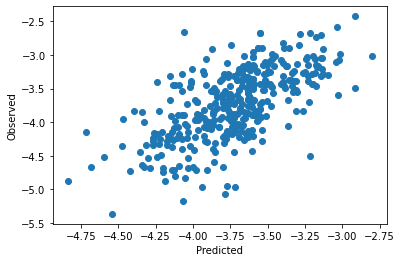

In [112]:
# Grab expected alphas
mu = trace_dm['mu'].T
mu_0 = mu.mean(1)

## Predicted vs. observed
plt.scatter(mu_0,ylog) 
plt.ylabel('Observed'),plt.xlabel('Predicted')

In [1091]:
# extract posterior dists for covariates
# out = pm.trace_to_dataframe(trace_dm)
# varnames = np.array(list(out), dtype=object)
# varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
# varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
# varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = np.repeat(reef_zone, nfg)
# # varnames[match(grep('manage_x',list(varnames)),list(varnames))] = np.repeat(manage, nfg)
# varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(np.repeat(manage, nfg))*2)

# out.columns=varnames
# out.to_csv('zinc_posterior_trace.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


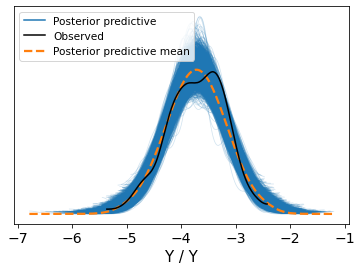

In [48]:
## posterior predictive distribution
with BDM:
    ppc = pm.sample_posterior_predictive(
        trace_dm, random_seed=43
    )

with BDM:
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc))

In [147]:
## extract posterior predicted 
extract_con(mu='mu2', varname = 'gravity')
extract_con(mu='mu3', varname = 'hard_coral')
extract_con(mu='mu4', varname = 'macroalgae')
extract_con(mu='mu5', varname = 'bare_substrate')
extract_con(mu='mu6', varname = 'turf')
extract_con(mu='mu7', varname = 'manage')
extract_con(mu='mu8', varname = 'pop')
extract_con(mu='mu9', varname = 'sediment')
extract_con(mu='mu10', varname = 'nut_load')
extract_con(mu='mu11', varname = 'rubble')
extract_con(mu='mu12', varname = 'future_hc')
extract_con(mu='mu13', varname = 'manage_nc')
extract_con(mu='mu14', varname = 'country')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [1266]:
futureHC[1:100]

array([-0.86969385, -0.86969385, -0.86969385, -0.86969385, -0.86969385,
       -0.86969385, -0.86969385, -0.86969385, -0.86969385, -0.86969385,
       -0.84467754, -0.84467754, -0.84467754, -0.84467754, -0.84467754,
       -0.84467754, -0.84467754, -0.84467754, -0.84467754, -0.84467754,
       -0.84467754, -0.81966123, -0.81966123, -0.81966123, -0.81966123,
       -0.81966123, -0.81966123, -0.81966123, -0.81966123, -0.81966123,
       -0.81966123, -0.81966123, -0.79464492, -0.79464492, -0.79464492,
       -0.79464492, -0.79464492, -0.79464492, -0.79464492, -0.79464492,
       -0.79464492, -0.79464492, -0.79464492, -0.76962861, -0.76962861,
       -0.76962861, -0.76962861, -0.76962861, -0.76962861, -0.76962861,
       -0.76962861, -0.76962861, -0.76962861, -0.76962861, -0.7446123 ,
       -0.7446123 , -0.7446123 , -0.7446123 , -0.7446123 , -0.7446123 ,
       -0.7446123 , -0.7446123 , -0.7446123 , -0.7446123 , -0.7446123 ,
       -0.71959599, -0.71959599, -0.71959599, -0.71959599, -0.71

In [142]:
 mus = trace_dm['mu2'].T

# get posterior mean
mu_0 = pd.DataFrame(mus.mean(1))
# mu_0.to_csv('turnover/Reef_zinc_posterior_'+varname+'.csv', index=False)

# get HPDI
Ex_hpd = az.hdi(mus)
# Ex_hpd_lo = Ex_hpd[:,1]
# Ex_hpd_hi = Ex_hpd[:,2]

# Ex_hpd_lo.to_csv('turnover/Reef_zinc_posterior_'+varname+'_hpd_lo.csv', index=False)
# Ex_hpd_hi.to_csv('turnover/Reef_zinc_posterior_'+varname+'_hpd_hi.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


array([0.05308581, 0.07734749, 0.04633016, ..., 0.02951462, 0.01566554,
       0.09012098])